In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cityseer.metrics import layers
from cityseer.tools import graphs, io


In [2]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


In [3]:
prems_gpd = gpd.read_file("data/madrid_premises/madrid_premises.gpkg")
prems_gpd.head()

,index,local_id,local_distr_id,local_distr_desc,local_neighb_id,local_neighb_desc,local_neighb_code,local_census_section_id,local_census_section_desc,section_id,section_desc,division_id,division_desc,epigraph_id,epigraph_desc,easting,northing,geometry
0,0,10003324,1,CENTRO,105,UNIVERSIDAD,5,1091,91,I,hospitality,56,food_bev,561001,RESTAURANTE,440181.6,4475586.5,POINT (440181.6 4475586.5)
1,1,10003330,1,CENTRO,105,UNIVERSIDAD,5,1115,115,R,art_rec_entert,90,creat_entert,900003,TEATRO Y ACTIVIDADES ESCENICAS REALIZADAS EN D...,440000.6,4474761.5,POINT (440000.6 4474761.5)
2,2,10003356,1,CENTRO,104,JUSTICIA,4,1074,74,I,hospitality,56,food_bev,561004,BAR RESTAURANTE,440618.6,4474692.5,POINT (440618.6 4474692.5)
3,3,10003364,1,CENTRO,104,JUSTICIA,4,1075,75,G,wholesale_retail_motor,47,retail,472401,COMERCIO AL POR MENOR DE PAN Y PRODUCTOS DE PA...,440666.6,4474909.5,POINT (440666.6 4474909.5)
4,4,10003367,1,CENTRO,106,SOL,6,1119,119,G,wholesale_retail_motor,47,retail,477701,"COMERCIO AL POR MENOR DE JOYAS, RELOJERIA Y BI...",440378.6,4474380.5,POINT (440378.6 4474380.5)


In [4]:
# compute accessibility
distances = [800, 1600]
nodes_gdf, prems_gpd = layers.compute_accessibilities(
    prems_gpd,
    landuse_column_label="division_desc",
    accessibility_keys=["retail"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)
# keep a copy before adding GTFS for comparison
for col in nodes_gdf.columns:
    if col.startswith("cc_"):
        nodes_gdf[f"{col}_not"] = nodes_gdf[col]

INFO:cityseer.metrics.layers:Computing land-use accessibility for: retail
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 117358 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Finished assigning data. 198773 assignments added to 24576 nodes.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.
INFO:cityseer.config:Distance: 1600m, Beta: 0.0025, Walking Time: 20.0 minutes.


In [5]:
network_structure, stops, avg_stop_pairs = io.add_transport_gtfs(
    "data/madrid_gtfs/madrid_metro",
    network_structure,
    nodes_gdf.crs,
)


INFO:cityseer.tools.io:Loading GTFS data from data/madrid_gtfs/madrid_metro
INFO:cityseer.tools.io:Loaded 1272 stops and 2360 stop times
INFO:cityseer.tools.io:Adding GTFS stops to network nodes (with street linking logic).
INFO:cityseer.tools.io:Generating segment durations between stops.
INFO:cityseer.tools.io:Adding GTFS segments to network edges.
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


In [6]:
# convert stops to geopandas
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops["stop_lon"], stops["stop_lat"]),
    crs=4326,  # Adjust the CRS to suit your data if needed
)
stops_gdf = stops_gdf.to_crs(streets_gpd.crs.to_epsg())
stops_gdf

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,avg_wait_time,geometry
0,gtfs-data/madrid_gtfs/madrid_metro-par_4_1,1,PLAZA DE CASTILLA,Paseo de la Castellana 189,40.46690,-3.68917,A,http://www.crtm.es,0,est_90_21,NaN,0,430.357143,POINT (441575.052 4479808.7)
1,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1,1,Plaza de Castilla,Paseo de la Castellana 189,40.46682,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441574.135 4479799.826)
2,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1040,1,Ascensor,Plaza de Castilla 9,40.46555,-3.68877,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441607.793 4479658.584)
3,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1043,1,Intercambiador Superficie,Paseo de la Castellana 191 B,40.46728,-3.68915,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441577.077 4479850.867)
4,gtfs-data/madrid_gtfs/madrid_metro-acc_4_1_1044,1,Ascensor,Paseo de la Castellana 189,40.46702,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0,NaN,POINT (441574.308 4479822.026)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,gtfs-data/madrid_gtfs/madrid_metro-est_4_234,234,HOSPITAL SEVERO OCHOA,Avda Orellana 3,40.32177,-3.76797,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434754.721 4463754.488)
1268,gtfs-data/madrid_gtfs/madrid_metro-est_4_235,235,LEGANES CENTRAL,Calle Virgen del Camino 1,40.32899,-3.77154,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434458.401 4464558.532)
1269,gtfs-data/madrid_gtfs/madrid_metro-est_4_236,236,SAN NICASIO,Avda Mar Mediterráneo SN,40.33616,-3.77587,B1,http://www.crtm.es,1,NaN,Europe/Madrid,2,NaN,POINT (434097.544 4465357.604)
1270,gtfs-data/madrid_gtfs/madrid_metro-par_4_237,237,OPERA,Plaza de Isabel II 9,40.41809,-3.70928,A,http://www.crtm.es,0,est_4_36,NaN,0,13.214286,POINT (439826.687 4474404.289)


In [7]:
nodes_gdf, prems_gpd = layers.compute_accessibilities(
    prems_gpd,
    landuse_column_label="division_desc",
    accessibility_keys=["retail"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: retail
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 117358 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Finished assigning data. 198773 assignments added to 24576 nodes.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.
INFO:cityseer.config:Distance: 1600m, Beta: 0.0025, Walking Time: 20.0 minutes.


In [8]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_retail_800_nw', 'cc_retail_800_wt',
       'cc_retail_1600_nw', 'cc_retail_1600_wt', 'cc_retail_nearest_max_1600',
       'cc_retail_800_nw_not', 'cc_retail_800_wt_not', 'cc_retail_1600_nw_not',
       'cc_retail_1600_wt_not', 'cc_retail_nearest_max_1600_not'],
      dtype='object')

In [9]:
nodes_gdf["cc_retail_800_wt_diff"] = (
    nodes_gdf["cc_retail_800_wt"] - nodes_gdf["cc_retail_800_wt_not"]
)

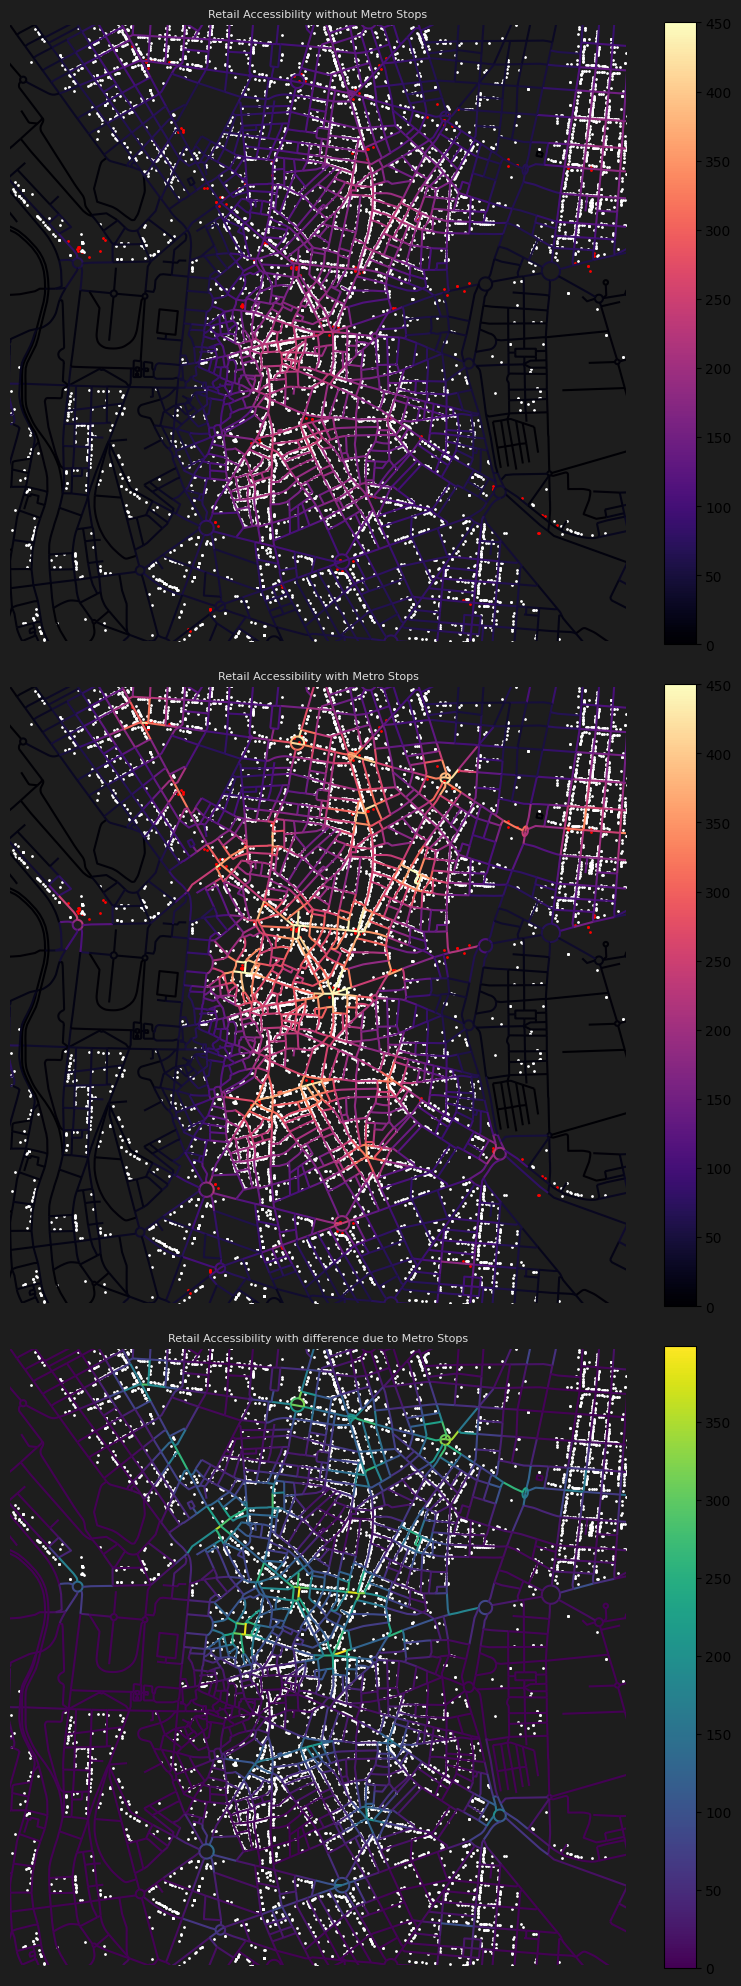

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 20), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_retail_800_wt_not",
    cmap="magma",
    legend=True,
    ax=axes[0],
    vmax=450,
)
axes[0].set_title(
    "Retail Accessibility without Metro Stops",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[0], color="red", markersize=1)

nodes_gdf.plot(
    column="cc_retail_800_wt",
    cmap="magma",
    legend=True,
    ax=axes[1],
    vmax=450,
)
axes[1].set_title(
    "Retail Accessibility with Metro Stops",
    fontsize=8,
    color="#ddd",
)
stops_gdf.plot(ax=axes[1], color="red", markersize=1)

nodes_gdf.plot(
    column="cc_retail_800_wt_diff",
    cmap="viridis",
    legend=True,
    ax=axes[2],
)
axes[2].set_title(
    "Retail Accessibility with difference due to Metro Stops",
    fontsize=8,
    color="#ddd",
)

for ax in axes:
    prems_gpd[prems_gpd["division_desc"] == "retail"].plot(
        markersize=1,
        edgecolor=None,
        color="white",
        legend=False,
        ax=ax,
    )
    ax.set_xlim(438500, 438500 + 3500)
    ax.set_ylim(4472500, 4472500 + 3500)
    ax.axis(False)

plt.tight_layout()